# Basic `PyTorch` Tutorial

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).

**_PyTorch_ is an open source machine learning] framework based on the Torch library, used for applications such as computer vision and natural language processing primarily developed by Meta AI.**

![torch](https://user-images.githubusercontent.com/42931974/68615320-d6bf3380-04e8-11ea-84f8-dcef049f1ed3.gif)


In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor


**PyTorch offers domain-specific libraries such as [TorchText](https://pytorch.org/text/stable/index.html), [TorchVision](https://pytorch.org/vision/stable/index.html), and [TorchAudio](https://pytorch.org/audio/stable/index.html), all of which include datasets. For this tutorial, we will be using a TorchVision dataset.**

**The `torchvision.datasets` module contains `Dataset` objects for many real-world vision data like CIFAR, COCO ([full list here](https://pytorch.org/vision/stable/datasets.html), or just use `dir(datasets)`).**

**In this tutorial, we use the FashionMNIST dataset. Every TorchVision `Dataset` includes two arguments: `transform` and `target_transform` to modify the samples and labels respectively.**


In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\train-labels-idx1-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to data\FashionMNIST\raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to data\FashionMNIST\raw



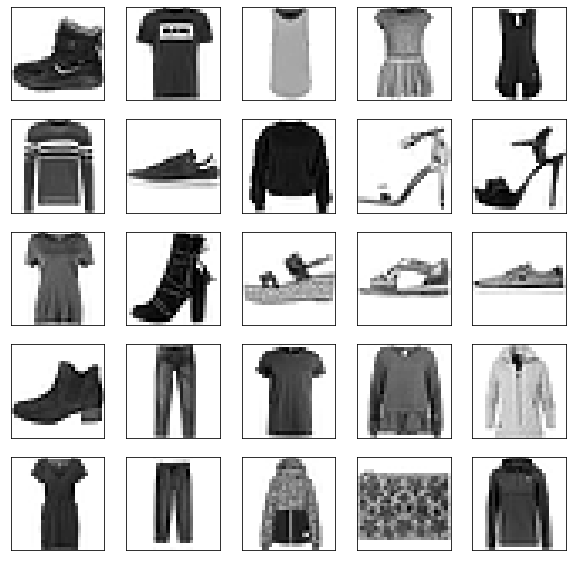

In [54]:
import matplotlib.pyplot as plt

plt.figure(figsize=[10, 10])
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(torch.squeeze(training_data[i][0]), cmap=plt.cm.binary)

plt.show()


**We pass the `Dataset` as an argument to `DataLoader`. This wraps an iterable over our dataset, and supports automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element in the dataloader iterable will return a batch of 64 features and labels.**


In [21]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in train_dataloader:
    print(f'Sixe of train_data: {len(train_dataloader.dataset)}')
    print(f'Sixe of test_data: {len(test_dataloader.dataset)}')
    print(f'Shape of X [Batch, Channels, Height, Width]: {X.shape}')
    print(f'Shape of y: {y.shape} {y.dtype}')
    break


Sixe of train_data: 60000
Sixe of test_data: 10000
Shape of X [Batch, Channels, Height, Width]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


### Creating Models

**To define a neural network in PyTorch, we create a class that inherits from `nn.Module`. We define the layers of the network in the `__init__` function and specify how data will pass through the network in the `forward` function. To accelerate operations in the neural network, we move it to the GPU if available.**


In [22]:

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)


Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Optimizing the Model Parameters

**To train a model, we need a `loss function` and an `optimizer`. In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and backpropagates the prediction error to adjust the model’s parameters. We also check the model’s performance against the test dataset to ensure it is learning.**


In [24]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f'>> Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]')


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(
        f"Test Error: \n>> Accuracy: {(100*correct):>0.1f}%\n>> Avg loss: {test_loss:>8f} \n")


**The training process is conducted over several iterations (_epochs_). During each epoch, the model learns parameters to make better predictions. We print the model’s accuracy and loss at each epoch; we’d like to see the accuracy increase and the loss decrease with every epoch.**


In [25]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)


Epoch 1
-------------------------------
>> Loss: 2.305553  [    0/60000]
>> Loss: 2.303820  [ 6400/60000]
>> Loss: 2.300169  [12800/60000]
>> Loss: 2.299034  [19200/60000]
>> Loss: 2.297869  [25600/60000]
>> Loss: 2.288891  [32000/60000]
>> Loss: 2.295819  [38400/60000]
>> Loss: 2.288770  [44800/60000]
>> Loss: 2.287611  [51200/60000]
>> Loss: 2.286525  [57600/60000]
Test Error: 
>> Accuracy: 22.3%
>> Avg loss: 2.289193 

Epoch 2
-------------------------------
>> Loss: 2.287213  [    0/60000]
>> Loss: 2.287534  [ 6400/60000]
>> Loss: 2.279682  [12800/60000]
>> Loss: 2.284722  [19200/60000]
>> Loss: 2.280427  [25600/60000]
>> Loss: 2.270073  [32000/60000]
>> Loss: 2.277981  [38400/60000]
>> Loss: 2.268724  [44800/60000]
>> Loss: 2.271352  [51200/60000]
>> Loss: 2.268009  [57600/60000]
Test Error: 
>> Accuracy: 30.1%
>> Avg loss: 2.268979 

Epoch 3
-------------------------------
>> Loss: 2.266663  [    0/60000]
>> Loss: 2.267492  [ 6400/60000]
>> Loss: 2.255182  [12800/60000]
>> Loss: 

### Saving Models

**A common way to save a model is to serialize the internal state dictionary (containing the model parameters). The process for loading a model includes re-creating the model structure and loading the state dictionary into it.**


In [26]:
torch.save(model.state_dict(), 'fashion_model.pth')
model = NeuralNetwork()
model.load_state_dict(torch.load('fashion_model.pth'))


<All keys matched successfully>

**This model can now be used to make predictions. Models usually outputs raw prediction `logits`. To convert them to probability you should use a `softmax function`.**


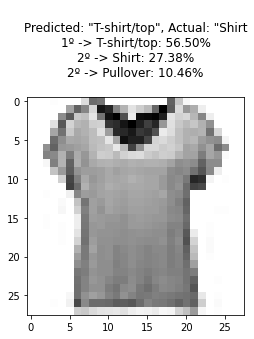

In [76]:
import torch.nn.functional as nnf
import numpy as np

model.eval()

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]
sample = np.random.randint(0, 9999)
x, y = test_data[sample][0], test_data[sample][1]

with torch.no_grad():
    pred = model(x)

prob = nnf.softmax(pred, dim=1)
top_p, top_class = prob.topk(3, dim=1)
predicted, actual = classes[top_class[0][0]], classes[y]

plt.imshow(torch.squeeze(test_data[sample][0]), cmap=plt.cm.binary)
plt.title(f'''
Predicted: "{predicted}", Actual: "{actual}
1º -> {classes[top_class[0][0]]}: {(top_p[0][0]*100):>0.2f}%
2º -> {classes[top_class[0][1]]}: {(top_p[0][1]*100):>0.2f}%
2º -> {classes[top_class[0][2]]}: {(top_p[0][2]*100):>0.2f}%
''')
plt.show()


**Pytorch gives the user greater visibility to much of what the Keras/Tensorflow library hides. However, in the end, both make sure the job gets done, and which one you choose to use (_you will probably use both if you want to practice ML_) is a matter of taste and preference!** 🙃

---

Return to the [castle](https://github.com/Nkluge-correa/teeny-tiny_castle).
